# Base Matrix Factorisation

In [1]:
# import modules
import numpy as np
import matplotlib.pyplot as plt
from tdc.multi_pred import DTI
import torch
from torch.utils.data import DataLoader
from rdkit import Chem

from BaseMF.RecSys import RatingDataset, MatrixFactorization
from BaseMF.ModelTrainer import train_model

## Data Loading

In [2]:
# load in the Kd dataset
# method also works with IC50 and Ki datasets
data = DTI(name = 'BindingDB_Kd')
data.convert_to_log(form = 'binding')

Found local copy...
Loading...
Done!
To log space...


## Data pre-processing

In [3]:
def data_split(data):
    # split data using tdc modules random split using default 0.7, 0.1, 0.2 split
    split = data.get_split(seed = 42)
    train = split['train']
    test = split['test']

    # enumerate drugs and targets for easy indexing
    ID_to_Drug = dict(enumerate(list(dict.fromkeys(train['Drug']))))
    ID_to_Target = dict(enumerate(list(dict.fromkeys(train['Target']))))
    Drug_to_ID = dict((v,k) for k,v in ID_to_Drug.items())
    Target_to_ID = dict((v,k) for k,v in ID_to_Target.items())
    
    return train, test, Drug_to_ID, Target_to_ID

def data_loader(data, drug_dict, target_dict):
    # allows data to be correctly passed in to PyTorch DataLoader
    
    # apply ID dictionary to both drugs and targets
    data["Drug_DictID"] = data["Drug"].apply(lambda x:drug_dict.get(x))
    data["Target_DictID"] = data["Target"].apply(lambda x:target_dict.get(x))

    # convert data into expected data types
    drug_ID = data["Drug_DictID"].to_numpy()
    target_ID = data["Target_DictID"].to_numpy()
    features = np.vstack((drug_ID, target_ID)).T
    label = data['Y'].to_numpy()
    return features, label

## Pytorch Matrix Factorisation model
Code for the base model including `MatrixFactorisation` class and the `train_model` function was obtained and optimised from a [Medium article](https://medium.com/@rinabuoy13/explicit-recommender-system-matrix-factorization-in-pytorch-f3779bb55d74)

### Training and Evaluation

In [4]:
bs = 100
n_factors = 20
num_epochs = 100

train, test, drug_dict, target_dict = data_split(data)
x_train, y_train = data_loader(train, drug_dict, target_dict)
x_test, y_test = data_loader(test, drug_dict, target_dict)

train_dataloader = DataLoader(RatingDataset(x_train, y_train), batch_size=bs, shuffle=True)
test_dataloader = DataLoader(RatingDataset(x_test, y_test), batch_size=bs)

model = MatrixFactorization(len(drug_dict), len(target_dict), n_factors)

train_losses, test_losses, trained_model = train_model(train_dataloader, test_dataloader, model, num_epochs)

epoch:  0  avg training loss:  28.744853009291685  avg test loss:  22.552714266095844
epoch:  5  avg training loss:  9.411021880113362  avg test loss:  8.825925954182942
epoch:  10  avg training loss:  6.962901553821043  avg test loss:  6.674741765430995
epoch:  15  avg training loss:  5.761123054014529  avg test loss:  5.582966150556292
epoch:  20  avg training loss:  4.952517388948326  avg test loss:  4.8439661979675295
epoch:  25  avg training loss:  4.3223791799910085  avg test loss:  4.268992957614717
epoch:  30  avg training loss:  3.8111890153806716  avg test loss:  3.805216727937971
epoch:  35  avg training loss:  3.4047574977405737  avg test loss:  3.43629849865323
epoch:  40  avg training loss:  3.0816787836330186  avg test loss:  3.1445257822672525
epoch:  45  avg training loss:  2.8213899979174464  avg test loss:  2.912009306181045
epoch:  50  avg training loss:  2.606839837598019  avg test loss:  2.7228774672462825
epoch:  55  avg training loss:  2.4254908924871454  avg te

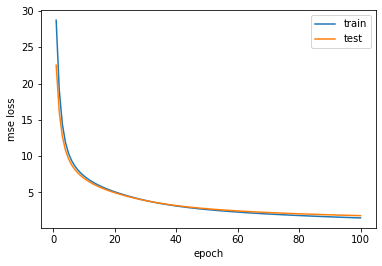

In [5]:
# Plotting training and test losses

epochs = range(1, num_epochs+1)
plt.plot(epochs, train_losses, label='train')
plt.plot(epochs, test_losses, label='test')
plt.xlabel('epoch')
plt.ylabel('mse loss')
plt.legend()
#     plt.savefig(img_name)
plt.show()

In [6]:
# Get predictions for test set

dev = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
predictions = []
for i, (test_batch, label_batch) in enumerate(test_dataloader):
    count = 1 + i
    with torch.no_grad():
        prediction = model(test_batch[:, 0].to(dev), test_batch[:, 1].to(dev))
        predictions.extend(list(prediction.cpu().numpy()))

In [7]:
from tdc import Evaluator
mse_evaluator = Evaluator(name = 'MSE')
mae_evaluator = Evaluator(name = 'MAE')

mse_score = mse_evaluator(y_test, predictions)
mae_score = mae_evaluator(y_test, predictions)

print('MSE: ', mse_score)
print('MAE: ', mae_score)

MSE:  1.8052563056542184
MAE:  0.8349585780629778
